In [8]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
from tensorflow.keras import (
    layers,
    models,
    callbacks,
    losses,
    utils,
    metrics,
    optimizers,
    datasets,
)
import pickle
import tensorflow.keras.backend as K
from winfoGAN.model import GAN
from classifier.classifier import CLASSIFICATION_MODEL
import librosa as lb
from IPython.lib.display import Audio
import IPython
import pandas as pd
import json

import scipy.signal
from scipy.fft import fft
from scipy.signal import spectrogram

In [9]:
def create_inputs(specs, num, bit_value= 1, baseline_dose = 0, random = False):
    latent_dim = specs["Latent Dim"]
    n_cat = specs["N Categories"]
    bits = range(n_cat)
    z_dim = latent_dim-n_cat

    if random:
        #print("Random c")
        z= tf.random.normal(shape=(num, z_dim))
        c = tf.random.normal(shape=(num, n_cat))
        #thresholding values to 0 and 1
        c = tf.cast(c < 0, dtype=tf.float32)
        inputs = [tf.concat([z,c], axis=1)]

    else:
        inputs = []
        for bit in bits:
            z= np.random.normal(size=(num, latent_dim))
            z[:,z_dim:]= baseline_dose
            z[:,z_dim+bit]=bit_value
            z= tf.convert_to_tensor(z, dtype=tf.float32)
            inputs.append(z)


    return inputs

In [5]:
gan_directory ="C:/Users/Jayde/Desktop/wavegan/zf10"
spec_path = f"{gan_directory}/model_specifications.json"
with open(spec_path, 'r') as f:
  specs = json.load(f)

classifier_directory ="C:/Users/Jayde/Desktop/classifier_2601.1554/classifier_2601.1554/"
spec_path = f"{classifier_directory}/model_specifications.json"
with open(spec_path, 'r') as f:
  classifier_specs = json.load(f)

In [4]:
gan = GAN(
    latent_dim = specs["Latent Dim"],
    discriminator_steps= specs["Discriminator Steps"],
    gp_weight= specs["GP Weight"],
    n_categories= specs["N Categories"],
    slice_len=16384,
)

classifier = CLASSIFICATION_MODEL(
   n_categories = specs["N Categories"],
   slice_len = specs["Slice Length"]
)

classifier = classifier.classifier
generator = gan.generator

In [10]:
classifier.load_weights(f"{classifier_directory}/classifier{25}")
generator.load_weights(f"{gan_directory}/generator")

In [22]:
inputs = create_inputs(specs,100,bit_value= 3, random =True)[0]
generated_audio = generator.predict(inputs) 
audio= np.squeeze(generated_audio)

4/4 [==============================] - 6s 1s/step


In [23]:
pred_labels = np.argmax(classifier.predict(audio), axis=1)

4/4 [==============================] - 3s 629ms/step


Text(0, 0.5, 'Number of Occurences')

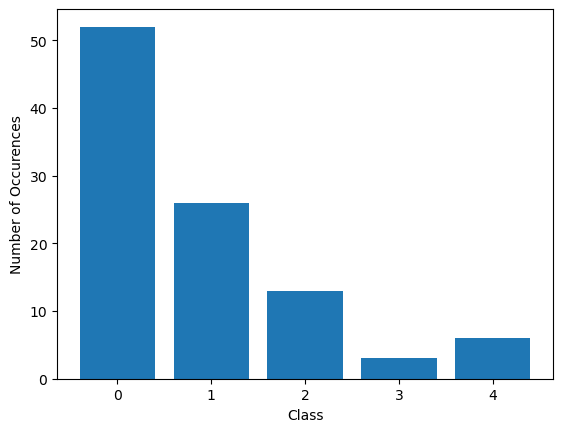

In [26]:
from collections import Counter
count =Counter(pred_labels)
plt.bar(count.keys(),count.values())
plt.xlabel("Class")
plt.ylabel("Number of Occurences")